Centro de Estudos e Sistemas Avançados do Recife

Pós-graduação em Engenharia e Análise de Dados

Disciplina de RNA e Deep Learning

Professor: Silvan Ferreira da Silva Junior 
 
Grupo:
* Anísio Pereira Batista Filho (apbf@cesar.school)
* Carlos Cezar Lopes de Mendonça (cclm@cesar.school)
* Rodolpho Victor França Valsconcelos (rvfv@cesar.school)

1. Fine-Tuning de uma CNN para Classificação

Um dataset de sua escolha deverá ser coletado e preparado para realizar o fine-tuning de uma CNN. O projeto será avaliado nos seguintes aspectos:
Construção do Dataset

* Data Augmentation
* Uso de Modelos Pré-Treinados
* Construção do Modelo Classificador
* Congelamento de Camadas
* Treinamento e Curvas de Desempenho

Dataset:

https://www.kaggle.com/datasets/shashanks1202/skin-cancer-dataset

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.models import MobileNet_V2_Weights, VGG16_Weights, ResNet18_Weights
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
def train_model(model, trainloader, valloader, criterion, optimizer, device=device, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }
    
    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')
        
        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history['train_losses'], label='Train')
    ax1.plot(history['val_losses'], label='Validation')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(history['train_accuracies'], label='Train')
    ax2.plot(history['val_accuracies'], label='Validation')
    ax2.set_title('Accuracy')
    ax2.legend()

    plt.show()


def test_model(model, testloader, device=device):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')

In [7]:
import shutil
from sklearn.model_selection import train_test_split

data_dir = 'data/skin_cancer_dataset/train_cancer'
train_dir = 'data/skin_cancer_dataset/working/train'
val_dir = 'data/skin_cancer_dataset/working/val'

for split_dir in [train_dir, val_dir]:
    for category in ['benign', 'malignant']:
        os.makedirs(os.path.join(split_dir, category), exist_ok=True)

def split_data(data_dir, train_dir, val_dir, split_ratio=(0.8, 0.2)):
    for category in ['benign', 'malignant']:
        category_path = os.path.join(data_dir, category)
        images = os.listdir(category_path)
        
        train_imgs, test_imgs = train_test_split(images, test_size=split_ratio[1], random_state=42)
        
        for img in train_imgs:
            shutil.copy(os.path.join(category_path, img), os.path.join(train_dir, category, img))
        
        for img in test_imgs:
            shutil.copy(os.path.join(category_path, img), os.path.join(val_dir, category, img))

split_data(data_dir, train_dir, val_dir)

In [8]:
# Carregando os datasets + Data augmentation
transform_aug = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_no_aug = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = "data/skin_cancer_dataset/working"

train_set = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_aug)
val_set = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_no_aug)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

In [9]:
# Uso de Modelos Pré-Treinados
model = models.resnet18(weights="IMAGENET1K_V1")

In [10]:
# Congelar todas as camadas
for param in model.parameters():
    param.requires_grad = False

In [11]:
# Substituir a última camada
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [13]:
# Treinando a CNN
history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)

100%|██████████| 7/7 [10:48<00:00, 92.60s/it] 


Epoch 1, Train Loss: 0.703, Train Accuracy: 61.57%
Epoch 1, Val Loss: 0.504, Val Accuracy: 88.89%


100%|██████████| 7/7 [10:42<00:00, 91.78s/it] 


Epoch 2, Train Loss: 0.613, Train Accuracy: 88.89%
Epoch 2, Val Loss: 0.616, Val Accuracy: 88.89%


100%|██████████| 7/7 [05:57<00:00, 51.00s/it]


Epoch 3, Train Loss: 0.501, Train Accuracy: 88.89%
Epoch 3, Val Loss: 0.315, Val Accuracy: 88.89%


100%|██████████| 7/7 [01:40<00:00, 14.32s/it]


Epoch 4, Train Loss: 0.227, Train Accuracy: 91.20%
Epoch 4, Val Loss: 0.324, Val Accuracy: 88.89%


100%|██████████| 7/7 [00:57<00:00,  8.15s/it]


Epoch 5, Train Loss: 0.253, Train Accuracy: 94.44%
Epoch 5, Val Loss: 0.237, Val Accuracy: 90.74%
Treinamento concluído


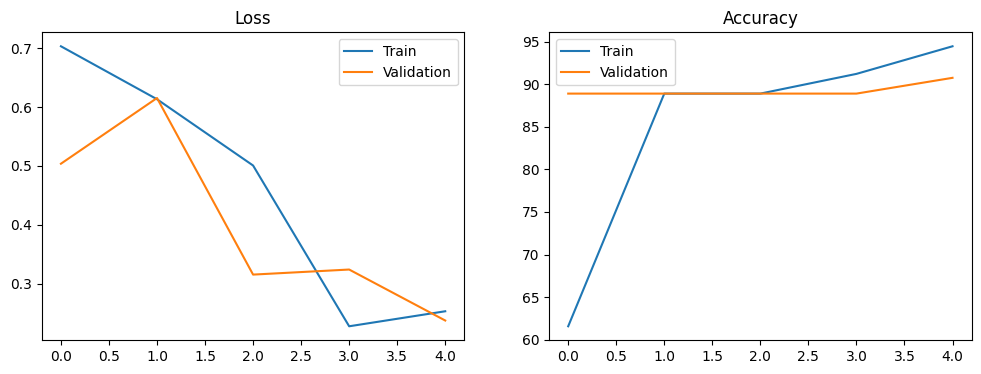

In [14]:
plot_history(history)

In [15]:
test_model(model, val_loader)

Acurácia da rede na base de teste: 90.74%


In [16]:
def plot_and_predict(model, image, class_names, device=device):
    model.eval()
    image = image.to(device)
    outputs = model(image.unsqueeze(0))
    _, predicted = torch.max(outputs.data, 1)
    probs = F.softmax(outputs, dim=1)[0] * 100
    prob = probs[predicted].item()

    # image between 0 and 1
    image = torch.clamp(image * 0.225 + 0.45, 0, 1)
    title = f'Classe: {class_names[predicted]} ({prob:.2f}%)'
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())
    plt.title(title)
    plt.axis('off')
    plt.show()

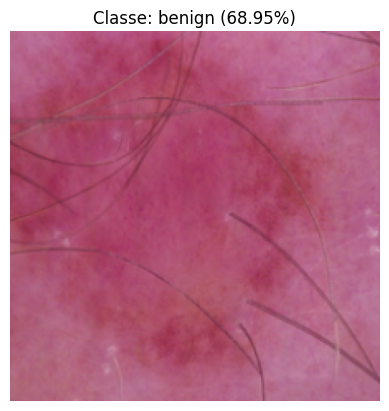

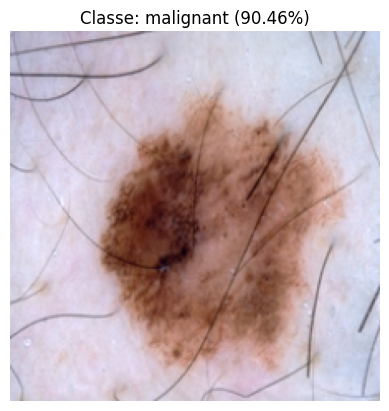

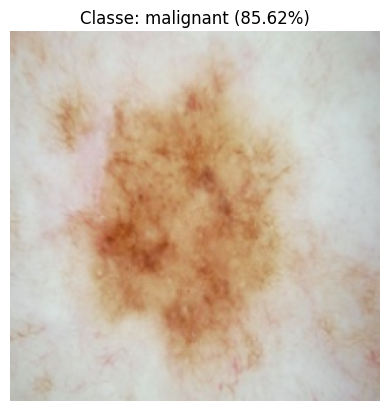

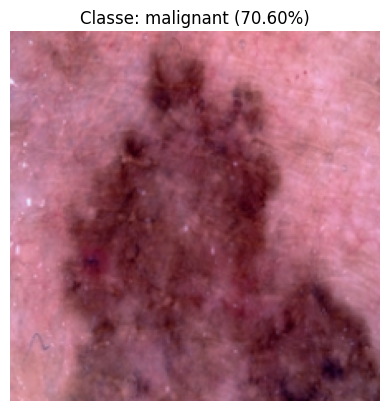

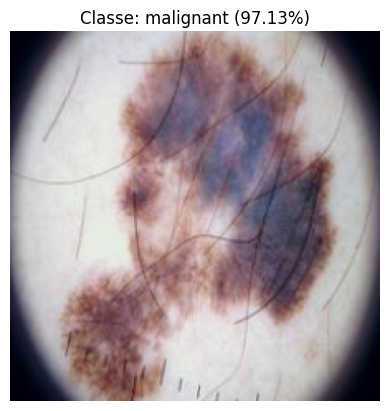

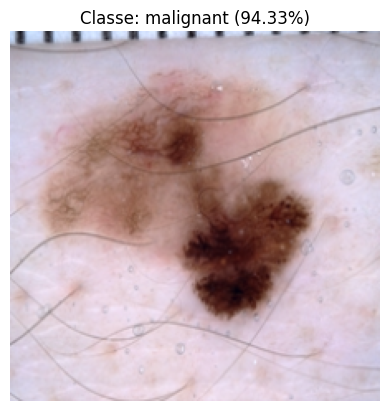

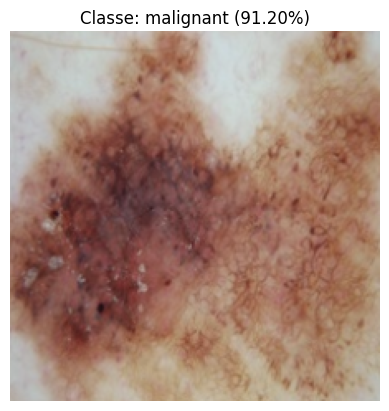

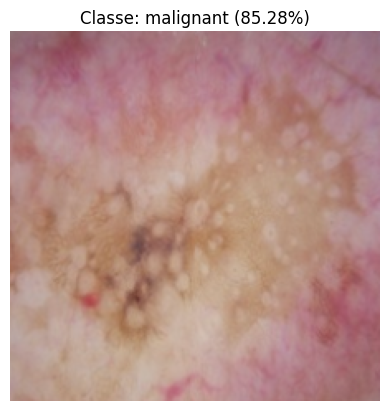

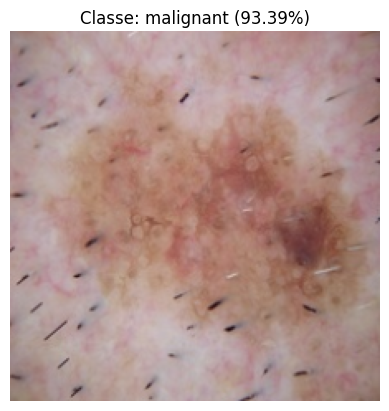

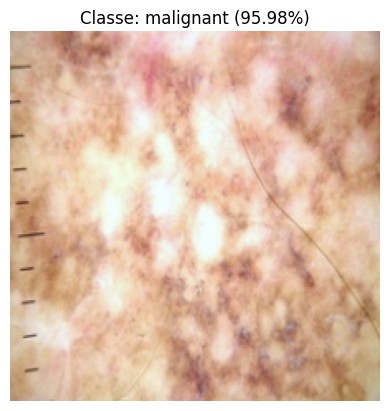

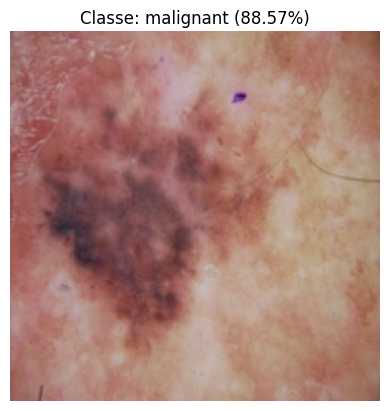

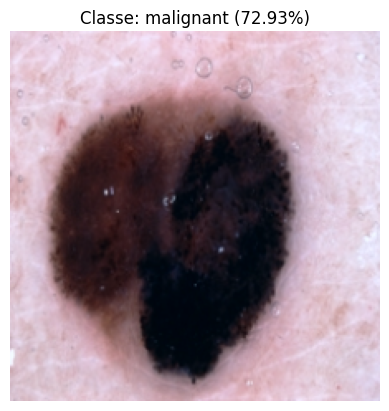

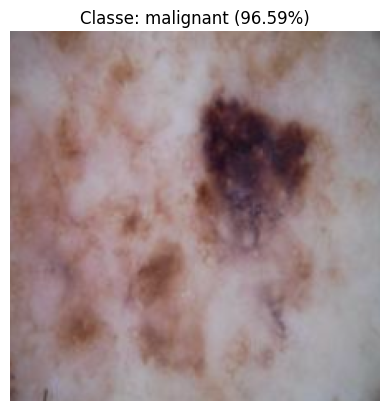

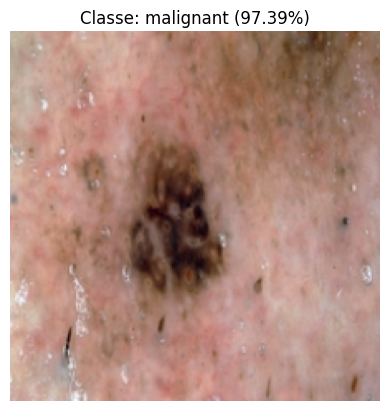

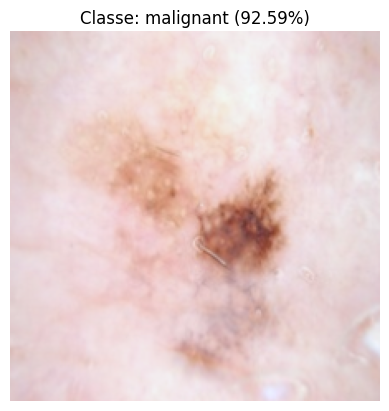

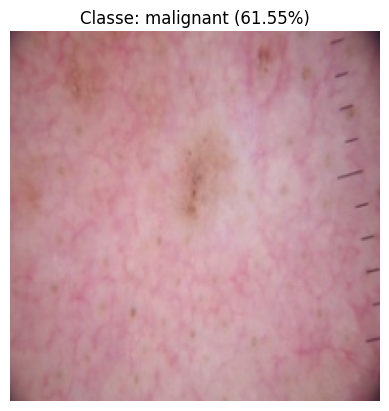

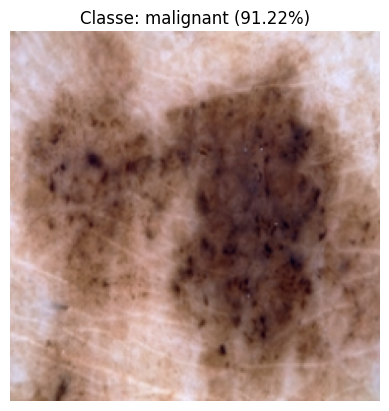

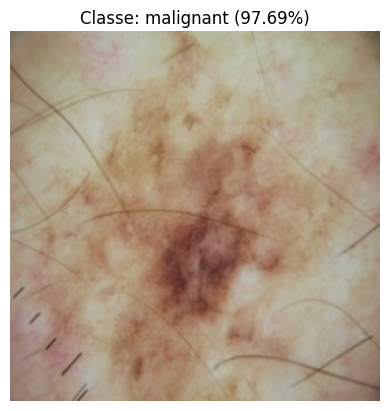

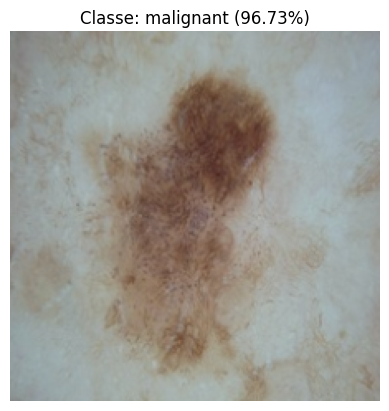

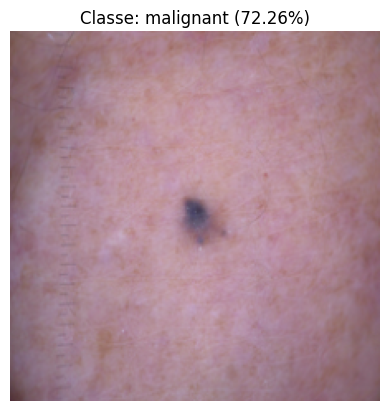

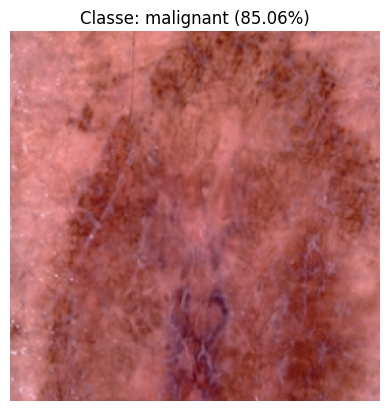

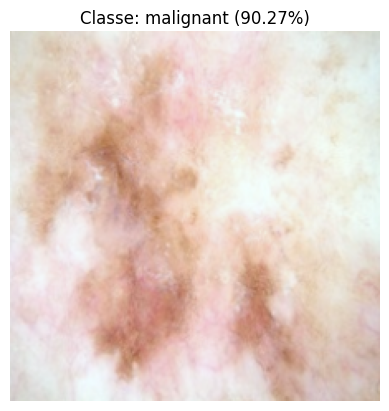

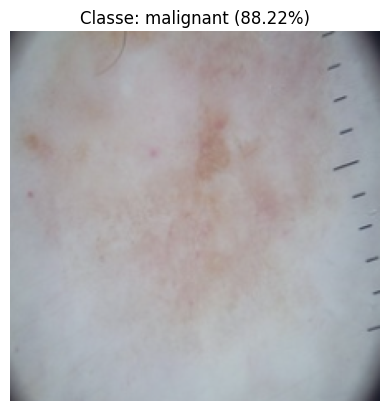

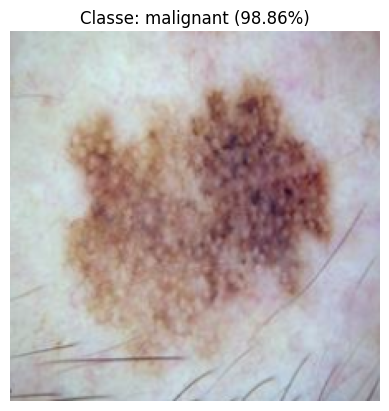

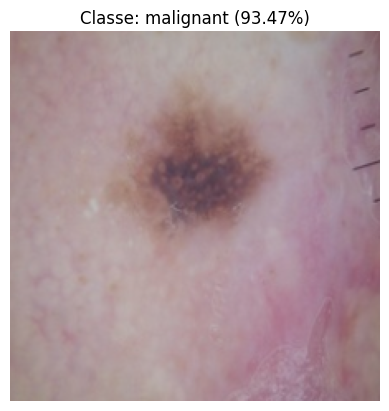

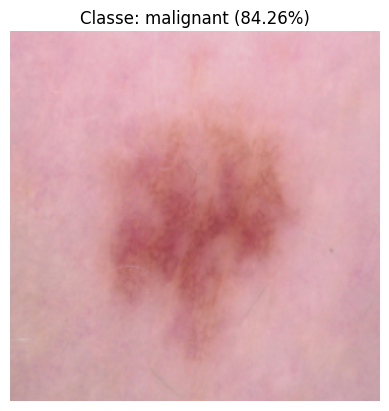

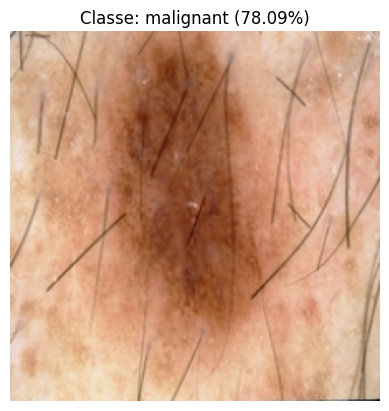

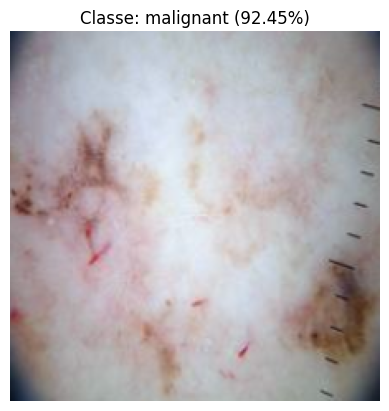

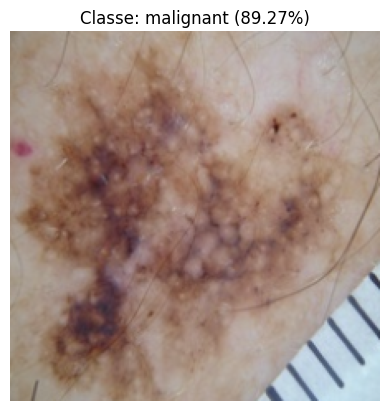

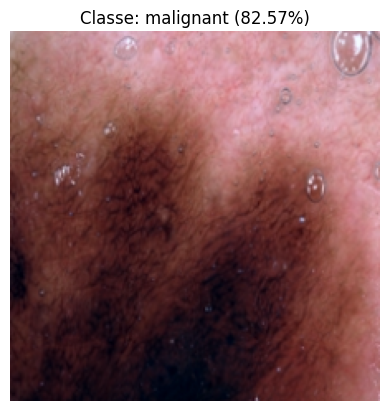

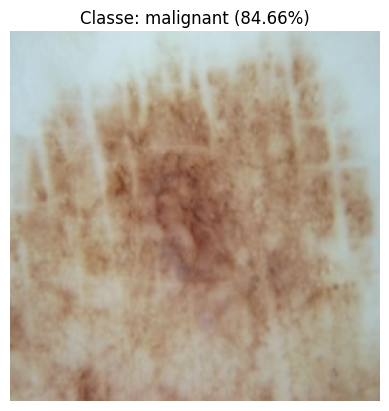

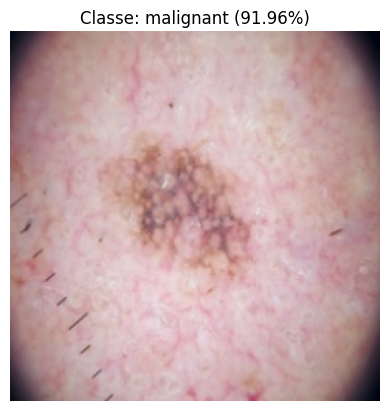

In [17]:
images, labels = next(iter(val_loader))

for image, label in zip(images, labels):
    plot_and_predict(model, image, val_set.classes)